# Project Overview:
This project aims to develop a vision-based autonomous driving system that predicts the steering angle of a simulated self-driving car using deep learning. The solution is trained on front-camera images captured in a virtual environment. A custom convolutional neural network, inspired by NVIDIA's end-to-end driving architecture but modified for performance and stability, is designed and trained to imitate human driving behavior.

Key enhancements include data balancing techniques to address steering angle bias, extensive data augmentation (zoom, pan, brightness adjustment, horizontal flipping), and image preprocessing (cropping, color space conversion, blurring, resizing, and normalization). The trained model is deployed in real-time using Flask and SocketIO, where it controls the simulator based on live image input, enabling the vehicle to steer autonomously. Throttle is managed using a simple feedback formula to maintain a safe and stable speed.

# Importing Neccessary Libraries

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
import seaborn as sns
from imgaug import augmenters as iaa

# Data Loading and Pre-Processing

In [2]:
datadir = 'trackdata'
columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Reverse', 'Speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

In [3]:
data.head(5)

Center  ...     Speed
0  C:\Users\Kush bansal\OneDrive\Desktop\Deep Lea...  ...  1.348132
1  C:\Users\Kush bansal\OneDrive\Desktop\Deep Lea...  ...  1.332839
2  C:\Users\Kush bansal\OneDrive\Desktop\Deep Lea...  ...  1.314690
3  C:\Users\Kush bansal\OneDrive\Desktop\Deep Lea...  ...  1.299733
4  C:\Users\Kush bansal\OneDrive\Desktop\Deep Lea...  ...  1.284925

[5 rows x 7 columns]

In [5]:
def img_name(path):
    head, tail = ntpath.split(path)
    return tail

data['Center'] = data['Center'].apply(img_name)
data['Left'] = data['Left'].apply(img_name)
data['Right'] = data['Right'].apply(img_name)

The function img_name(path) is designed to extract only the image file name from a full file path, using the ntpath.split() method, which splits a file path into two parts: the head (directory path) and the tail (file name). Here, only the tail (i.e., the file name with extension like "image_001.jpg") is returned, discarding the rest of the path (like "C:/Users/Folder/IMG/"). This function is then applied to each value in the 'Center', 'Left', and 'Right' columns of the data DataFrame using the .apply() method, which means for each image path stored in these columns (likely from a self-driving car dataset with center, left, and right camera images), only the image file name is retained. This simplification is useful when working with image data where the images are stored in a common directory and full paths are not needed for further processing.

In [6]:
data.head()

Center                              Left  ... Reverse     Speed
0  center_2025_07_12_01_42_28_739.jpg  left_2025_07_12_01_42_28_739.jpg  ...     0.0  1.348132
1  center_2025_07_12_01_42_28_842.jpg  left_2025_07_12_01_42_28_842.jpg  ...     0.0  1.332839
2  center_2025_07_12_01_42_28_949.jpg  left_2025_07_12_01_42_28_949.jpg  ...     0.0  1.314690
3  center_2025_07_12_01_42_29_050.jpg  left_2025_07_12_01_42_29_050.jpg  ...     0.0  1.299733
4  center_2025_07_12_01_42_29_151.jpg  left_2025_07_12_01_42_29_151.jpg  ...     0.0  1.284925

[5 rows x 7 columns]

In [12]:
data.shape

(5148, 7)

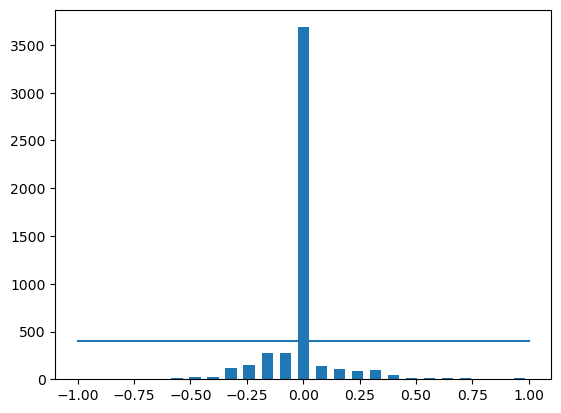

In [16]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['Steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samples_per_bin, samples_per_bin))

This code analyzes and visualizes the distribution of steering angle values from a dataset—typically used in self-driving car projects—to detect imbalance in the frequency of different steering commands. It begins by setting num_bins = 25, meaning the continuous range of data['Steering'] values will be divided into 25 equal-width intervals, and sets samples_per_bin = 400 as a reference threshold for how many samples per bin would be considered balanced. Using np.histogram, the code computes the number of samples falling into each bin (hist) and the bin edge boundaries (bins). Then, it calculates the center of each bin using (bins[:-1] + bins[1:]) * 0.5, which gives the x-axis positions for plotting. A bar chart is drawn using plt.bar(center, hist, width=0.05), where each bar represents the count of steering angles falling within a specific bin range. To assist in identifying overrepresented or underrepresented steering ranges, a horizontal line is drawn at y = 400 using plt.plot(...), which visually compares each bin's sample count to the ideal sample count per bin. This helps detect class imbalance (e.g., an overabundance of straight-driving samples near zero steering), which is critical to address before training a model, as an imbalanced dataset can bias the model toward common steering behaviors and reduce generalization to rare but important turns

In [28]:
# To remove biasness of straight driving samples
remove_list = []
for i in range(num_bins):
  list_ = []
  for j in range(len(data['Steering'])):
    if data['Steering'][j] >= bins[i] and data['Steering'][j] <= bins[i+1]:
      list_.append(j)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 3285
remaining: 1863


This code is used to balance the dataset by limiting the number of samples (data points) within each steering angle range, or bin, to a fixed number called samples_per_bin. First, it loops through all the bins (created earlier using np.histogram) and for each bin, it finds all the indices of data points whose steering angle falls within that bin's range (between bins[i] and bins[i+1]). These indices are stored in a temporary list called list_. It then shuffles this list randomly to avoid any bias in selection and keeps only the first samples_per_bin entries. The remaining indices—those that exceed the allowed limit for the bin—are added to remove_list. After processing all bins, the code prints how many data points are being removed, and then removes them from the original data DataFrame using their indices. Finally, it prints how many balanced samples remain in the dataset. This process helps to prevent the model from learning a bias toward steering angles that occur more frequently, such as driving straight, by equalizing the number of samples across all angle ranges.

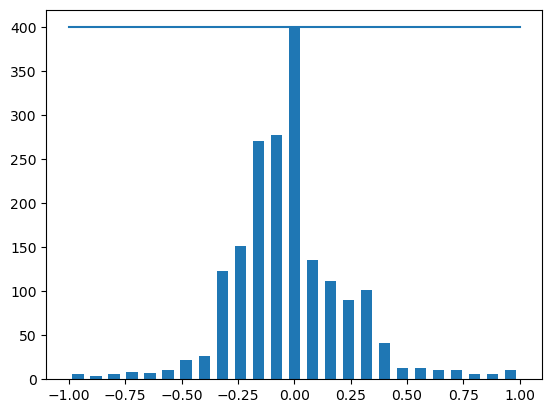

In [35]:
hist, bins = np.histogram(data['Steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samples_per_bin, samples_per_bin))

# Exploratory Data Analysis (EDA)

C:\Users\Kush bansal\AppData\Local\Temp\ipykernel_91400\3525691926.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Steering'])


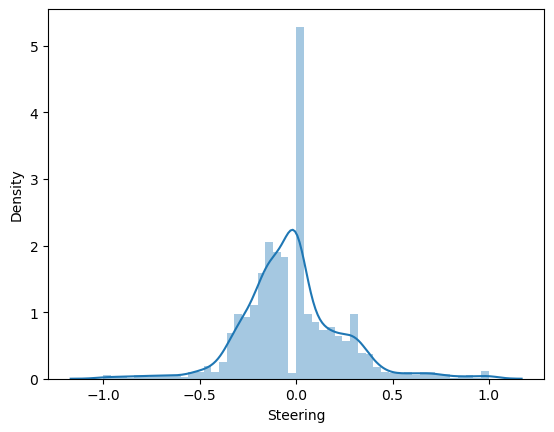

In [36]:
sns.distplot(data['Steering'])
plt.show()

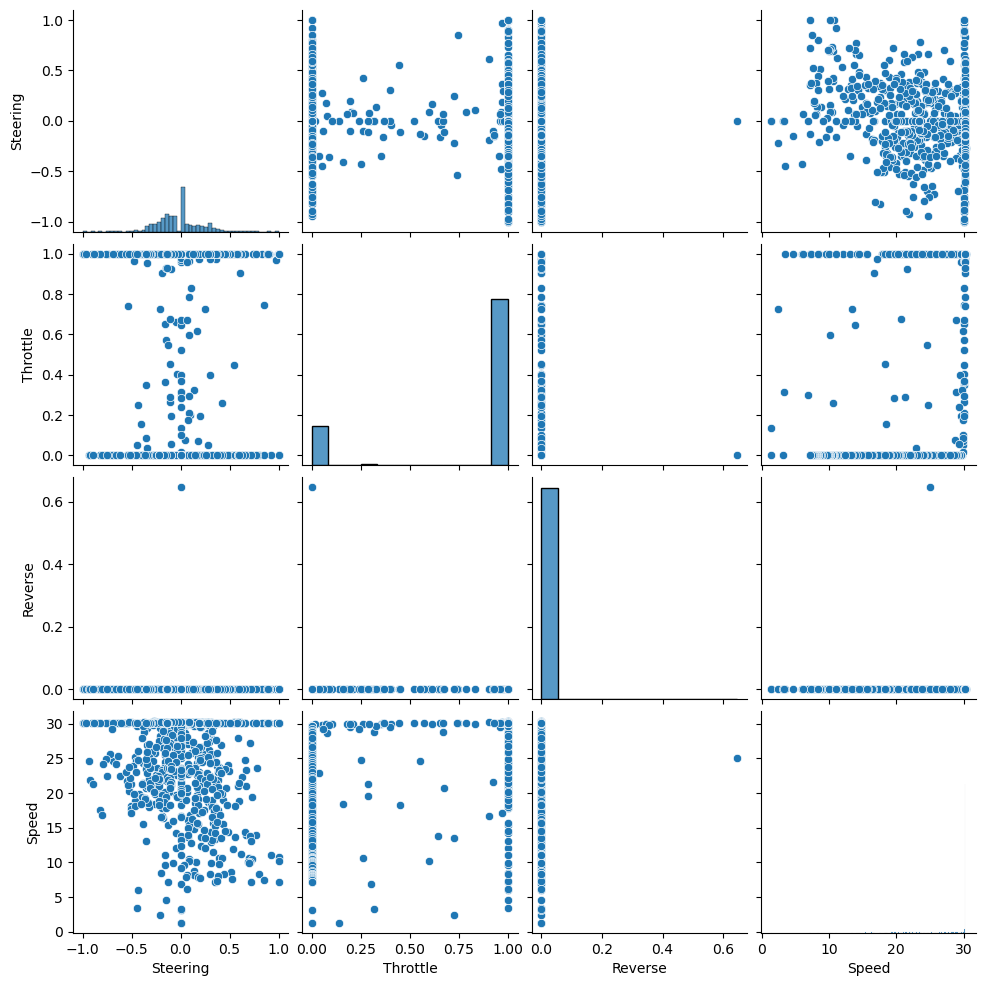

In [38]:
sns.pairplot(data)

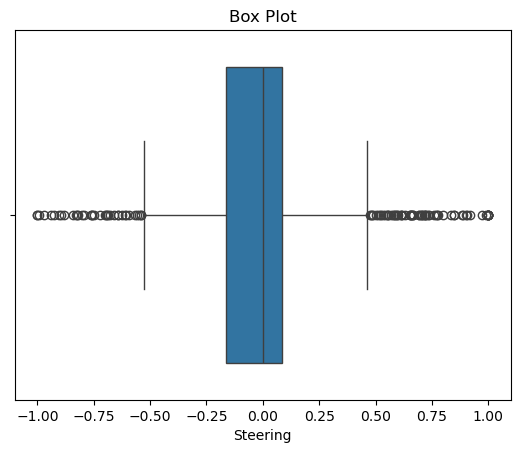

In [43]:
sns.boxplot(x=data['Steering'])
plt.title("Box Plot")
plt.show()

# Training and Validation Split

In [46]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

The load_img_steering(datadir, df) function prepares training data for a self-driving car model by generating a list of image paths along with their corresponding steering angles. For every row in the dataset, it reads the file names of the center, left, and right camera images, and the steering angle associated with the center image. It then constructs the full path to the center image using the base folder datadir and adds it to the list, keeping the original steering angle. To simulate what the car would do if it drifted left or right, the function also adds the left and right images, but with slight steering corrections: +0.15 for the left image (so the car learns to steer right and return to center) and −0.15 for the right image (to steer left). This augmentation helps the model generalize better by teaching it how to recover from off-center positions. Finally, the function converts the image paths and steering values into NumPy arrays and returns them for use in model training.

In [60]:
image_paths, steerings = load_img_steering(datadir + '\IMG', data)

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Kush bansal\AppData\Local\Temp\ipykernel_91400\2771515865.py:1: SyntaxWarning: invalid escape sequence '\I'
  image_paths, steerings = load_img_steering(datadir + '\IMG', data)
C:\Users\Kush bansal\AppData\Local\Temp\ipykernel_91400\2267315553.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
C:\Users\Kush bansal\AppData\Local\Temp\ipykernel_91400\2267315553.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexe

In [61]:
image_paths

array(['trackdata\\IMG\\center_2025_07_12_01_42_28_949.jpg',
       'trackdata\\IMG\\left_2025_07_12_01_42_28_949.jpg',
       'trackdata\\IMG\\right_2025_07_12_01_42_28_949.jpg', ...,
       'trackdata\\IMG\\center_2025_07_12_01_52_04_984.jpg',
       'trackdata\\IMG\\left_2025_07_12_01_52_04_984.jpg',
       'trackdata\\IMG\\right_2025_07_12_01_52_04_984.jpg'], dtype='<U48')

In [63]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

In [64]:
print("The length of image data is: ", len(image_paths))
print("The length of steering data is: ", len(steerings))

The length of image data is:  5589
The length of steering data is:  5589


In [66]:
x_train, x_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

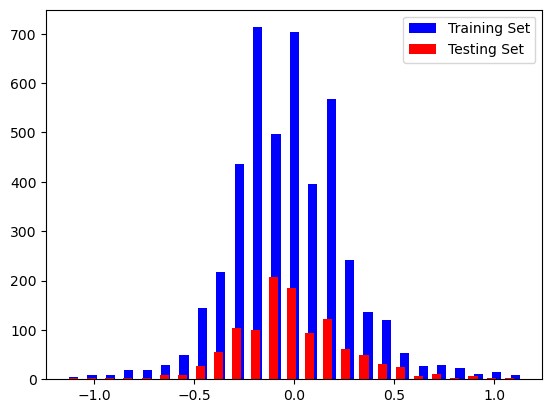

In [72]:
plt.hist(y_train, num_bins, rwidth=0.5, color='blue', label = "Training Set")
plt.hist(y_test, num_bins, rwidth=0.5, color='red', label = "Testing Set")
plt.legend()
plt.show()

# Data Augmentation

**zoom(image)**
This function applies a zoom effect to the input image. It uses iaa.Affine(scale=(1, 1.3)), which means the image is zoomed in randomly between 100% (no zoom) to 130%. This helps to simulate the scenario where the car moves closer to an object, making it appear larger in the camera view. It helps the self-driving model learn how to handle such perspective changes during driving.

(-0.5, 319.5, 159.5, -0.5)

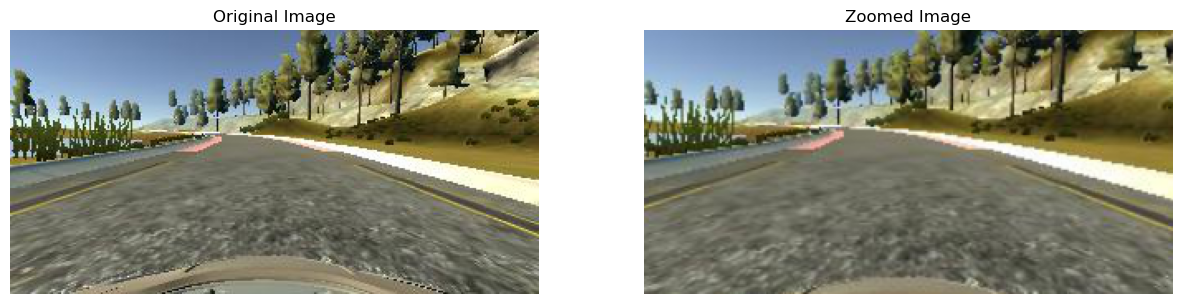

In [82]:
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image = zoom.augment_image(image)
    return image 

image = image_paths[random.randint(0, 5500)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

plt.figure(figsize=(15, 10))

# First subplot - Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Second subplot - Zoomed image
plt.subplot(1, 2, 2)
plt.imshow(zoomed_image)
plt.title('Zoomed Image')
plt.axis('off')

(-0.5, 319.5, 159.5, -0.5)

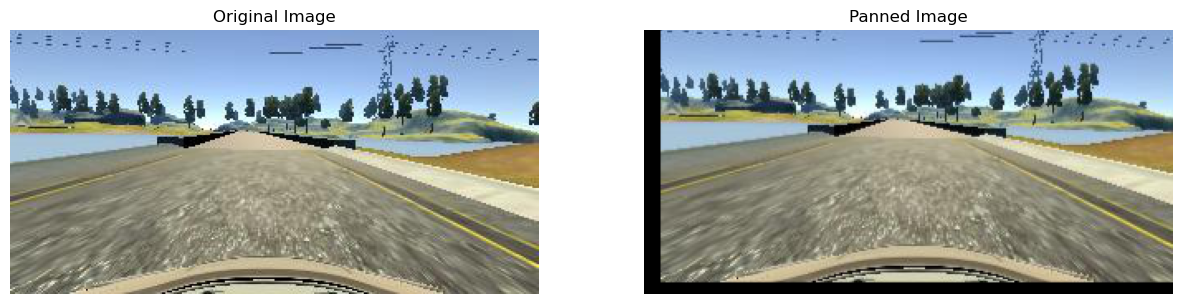

In [88]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image 

image = image_paths[random.randint(0, 5500)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

plt.figure(figsize=(15, 10))

# First subplot - Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Second subplot - Panned image
plt.subplot(1, 2, 2)
plt.imshow(panned_image)
plt.title('Panned Image')
plt.axis('off')

**pan(image)**
This function performs a panning or shifting effect on the image. Using iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}), the image is shifted horizontally and vertically by up to ±10% of its size. This simulates the car slightly moving left, right, up, or down — useful for teaching the model to recover from off-center positions and stay within the lane.

(-0.5, 319.5, 159.5, -0.5)

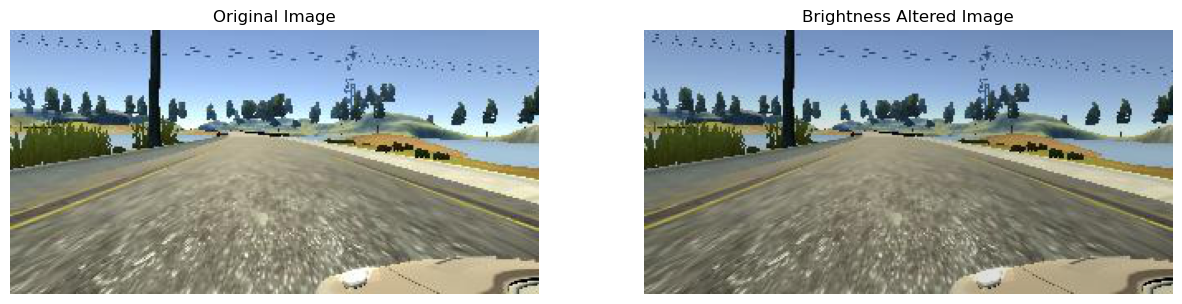

In [89]:
def random_brightness(image):
    bright = iaa.Multiply((0.2, 1.2))
    image = bright.augment_image(image)
    return image 

image = image_paths[random.randint(0, 5500)]
original_image = mpimg.imread(image)
bright_image = random_brightness(original_image)

plt.figure(figsize=(15, 10))

# First subplot - Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Second subplot - Bright image
plt.subplot(1, 2, 2)
plt.imshow(bright_image)
plt.title('Brightness Altered Image')
plt.axis('off')

**random_brightness(image)**
This function randomly adjusts the brightness of the image using iaa.Multiply((0.2, 1.2)). The pixel values are multiplied by a number between 0.2 (much darker) and 1.2 (brighter). This helps simulate different lighting conditions such as bright sunlight, shadows, or overcast weather, making the model more adaptable to real-world scenarios.

(-0.5, 319.5, 159.5, -0.5)

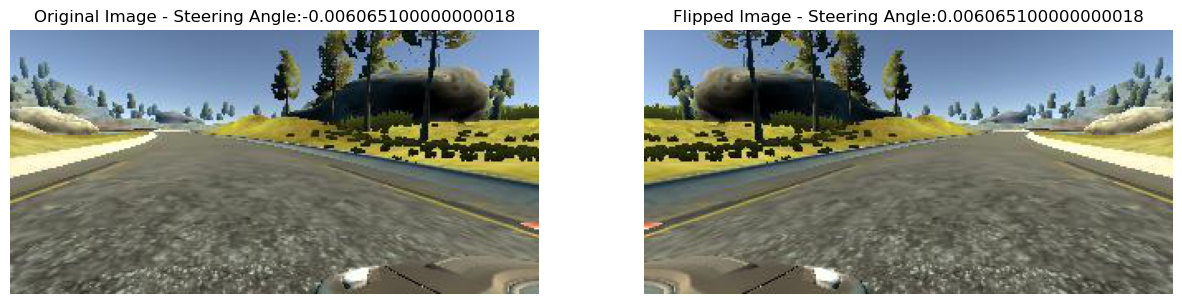

In [93]:
def flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 5500)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = flip(original_image, steering_angle)

plt.figure(figsize=(15, 10))

# First subplot - Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
plt.axis('off')

# Second subplot - flipped image
plt.subplot(1, 2, 2)
plt.imshow(flipped_image)
plt.title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))
plt.axis('off')

**flip(image, steering_angle)**
This function flips the image horizontally (like a mirror) using cv2.flip(image, 1). When an image is flipped, a left turn becomes a right turn and vice versa. So, the steering angle is also inverted (multiplied by -1). This is a powerful way to balance the dataset — especially if most of the original images involve turning in only one direction — by artificially creating the opposite turn.

In [94]:
def data_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = flip(image, steering_angle)

    return image, steering_angle

**data_augment(image, steering_angle)**
This is the main augmentation function that calls all the above transformations randomly. It first loads the image using mpimg.imread(image), then applies each augmentation (pan, zoom, brightness, flip) with a 50% chance each (np.random.rand() < 0.5). This randomness ensures that every image passed through this function may look slightly different, even if it's the same base image. This helps prevent overfitting and improves the model’s ability to generalize to unseen road conditions.


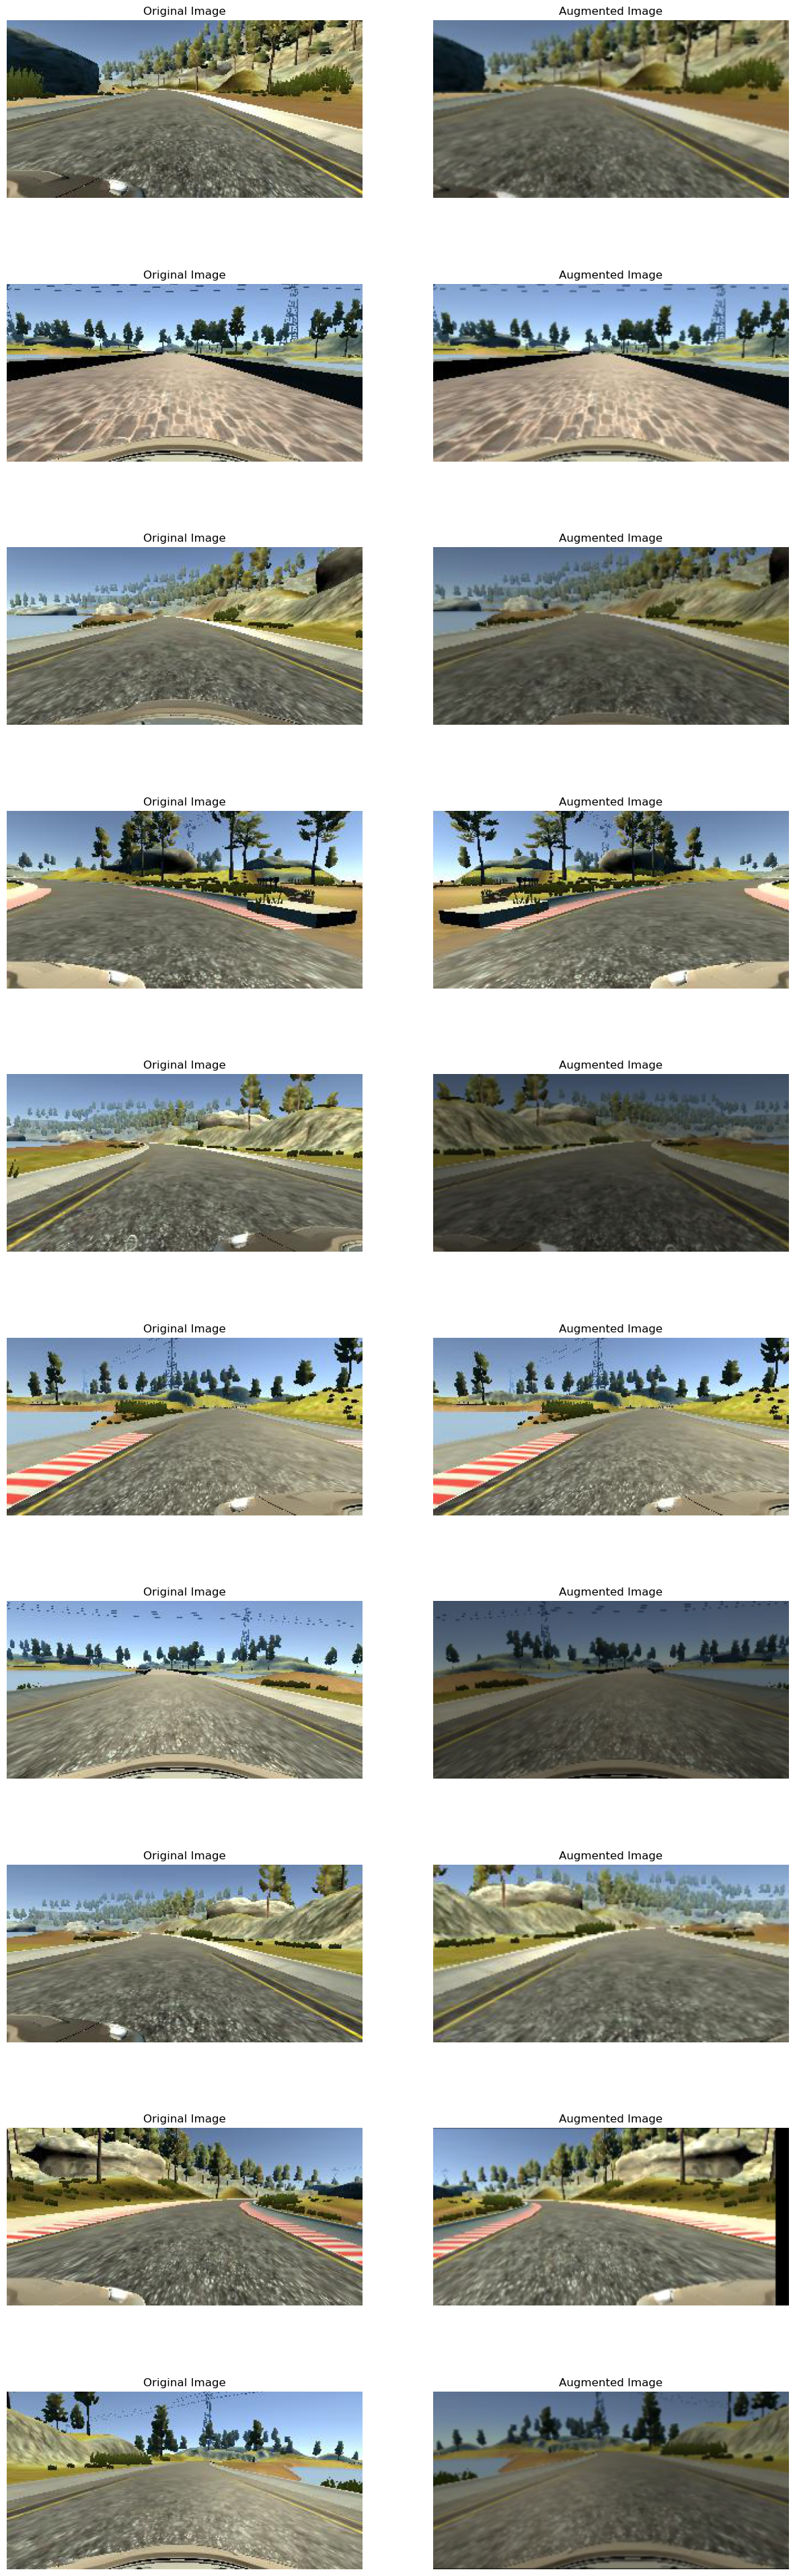

In [96]:
ncol = 2
nrow = 10

plt.figure(figsize=(15, 50))  # Set the overall figure size

for i in range(nrow):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = data_augment(random_image, random_steering)

    # Original image subplot (left column)
    plt.subplot(nrow, ncol, 2 * i + 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Augmented image subplot (right column)
    plt.subplot(nrow, ncol, 2 * i + 2)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")
    plt.axis('off')
plt.show()

# Image Preprocessing

In [108]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

The **img_preprocess** function prepares a raw driving image for training a self-driving car model by performing a sequence of targeted transformations aimed at enhancing relevant features and reducing unnecessary information. First, the image is cropped using img[60:135, :, :], which removes the top (usually sky) and bottom (usually the car's hood) portions of the frame, leaving only the middle section where the road lies — the most critical area for navigation. Then, the color space is converted from RGB to YUV using cv2.cvtColor, as YUV separates luminance (Y, brightness) from chrominance (U and V, color), making it easier for the model to focus on road structure and shapes, and this is especially useful for steering angle prediction. Next, a Gaussian blur with a 3×3 kernel is applied using cv2.GaussianBlur to reduce image noise and smooth sharp variations, helping the model generalize better without overfitting to fine pixel-level details. After blurring, the image is resized to 200×66 pixels using cv2.resize, inspired by NVIDIA's end-to-end self-driving model architecture and also reduces computational cost. Finally, the image pixel values are normalized to the range [0, 1] by dividing by 255 (img = img / 255), ensuring consistent input scaling and improving training stability and convergence speed during backpropagation.

Text(0.5, 1.0, 'Preprocessed Image')

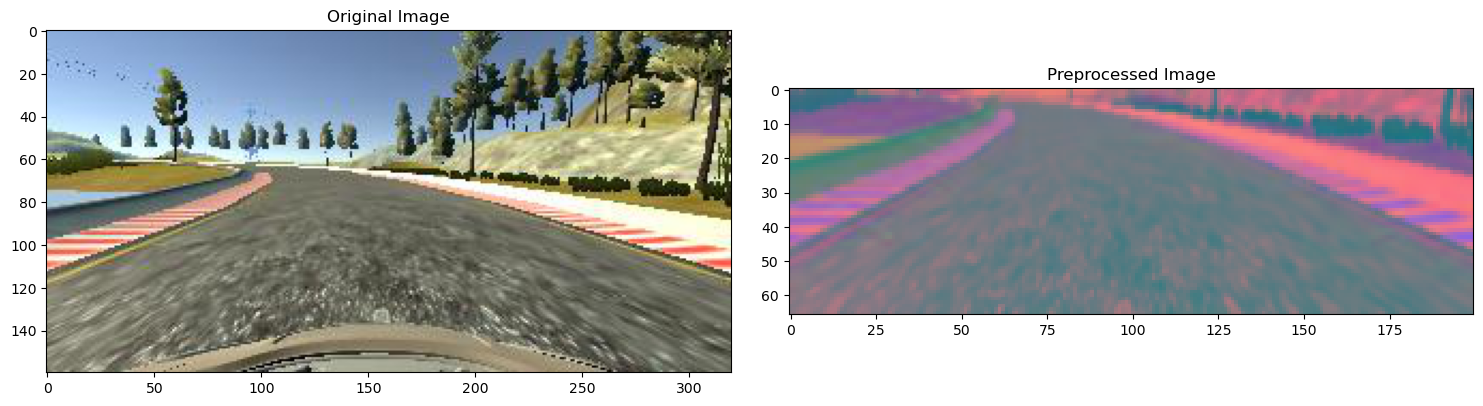

In [109]:
image = image_paths[300]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

# Batch Generator 

In [110]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        img, steering = data_augment(image_paths[random_index], steering_ang[random_index])

      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

The **batch_generator** function is designed to continuously generate batches of image and steering angle data for training or validation in a deep learning model, especially for self-driving car applications. It takes in a list of image file paths, their corresponding steering angles, a batch size, and a flag `istraining` that determines whether data augmentation should be applied. Inside an infinite `while True` loop (needed for real-time training), it randomly selects `batch_size` number of images. If `istraining` is `True`, the function applies the `data_augment` function (which performs random transformations like zoom, pan, flip, etc.) to simulate diverse driving conditions. If not, it just loads the original image. Regardless of augmentation, every selected image is then passed through the `img_preprocess` function (for cropping, color conversion, resizing, etc.) to prepare it for the model. The preprocessed images and corresponding steering angles are collected into lists, converted to NumPy arrays, and returned using `yield`, making this function a **Python generator** that streams batches efficiently to the model during training or validation without loading all data into memory at once.


Text(0.5, 1.0, 'validation Image')

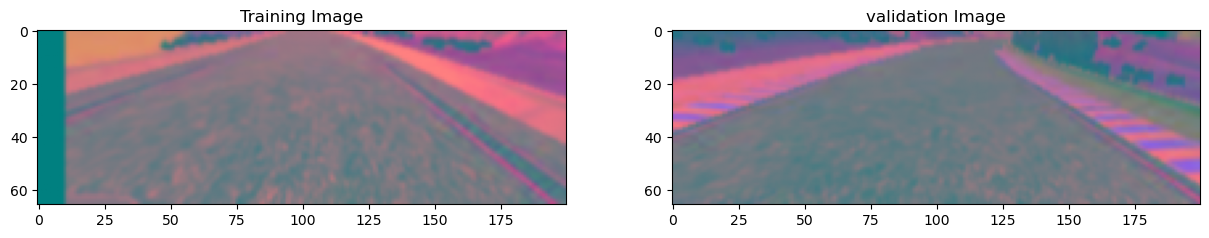

In [115]:
# Visualizing 
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_test, y_test, 1, 0))

plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(x_train_gen[0])
plt.title("Training Image")

plt.subplot(1,2,2)
plt.imshow(x_valid_gen[0])
plt.title("validation Image")

# Model Building and Training

In [137]:
model = Sequential()

model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (5, 5), activation='elu'))

model.add(Flatten())

model.add(Dense(100, activation = 'elu'))
model.add(Dense(50, activation = 'elu'))
model.add(Dense(10, activation = 'elu'))

model.add(Dense(1))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [138]:
from tensorflow.keras.losses import MeanSquaredError
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = MeanSquaredError()
model.compile(loss=loss_fn, optimizer=optimizer)

In [139]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 18, 64)           │          76,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
history = model.fit(batch_generator(x_train, y_train, 100, 1),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batch_generator(x_test, y_test, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle = 1)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - loss: 0.1588 - val_loss: 0.0569
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - loss: 0.0583 - val_loss: 0.0458
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - loss: 0.0526 - val_loss: 0.0379
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - loss: 0.0453 - val_loss: 0.0403
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - loss: 0.0428 - val_loss: 0.0401
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: 0.0419 - val_loss: 0.0329
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - loss: 0.0392 - val_loss: 0.0348
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - loss: 0.0391 - val_loss: 0.0306
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - loss: 0.0374 - val_loss: 0.0330
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - loss: 0.0357 - val_loss: 0.0302


Text(0.5, 0, 'Epoch')

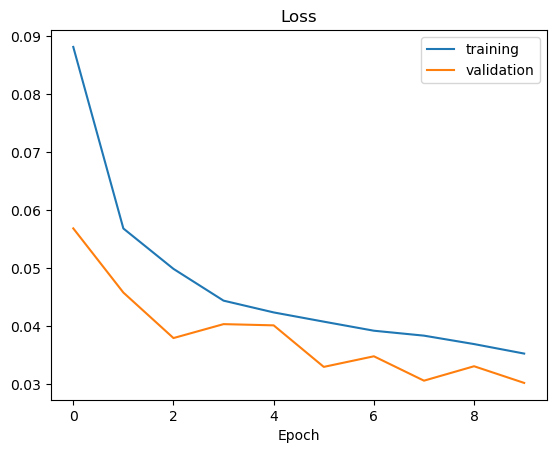

In [141]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [142]:
model.save('model.h5')